In [2]:
import os
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-05-21 02:35:10.453657: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 02:35:11.469190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# See the computing capability of the current GPU
# 3.5 and above is required
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-05-21 02:35:12.526994: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 02:35:12.730031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 02:35:12.730280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
train_files = []

mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])
print(train_files)

['lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_12.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_11.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_13.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_4.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_23.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_7.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_6.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_21.tif']
['lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_12_mask.tif', 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_

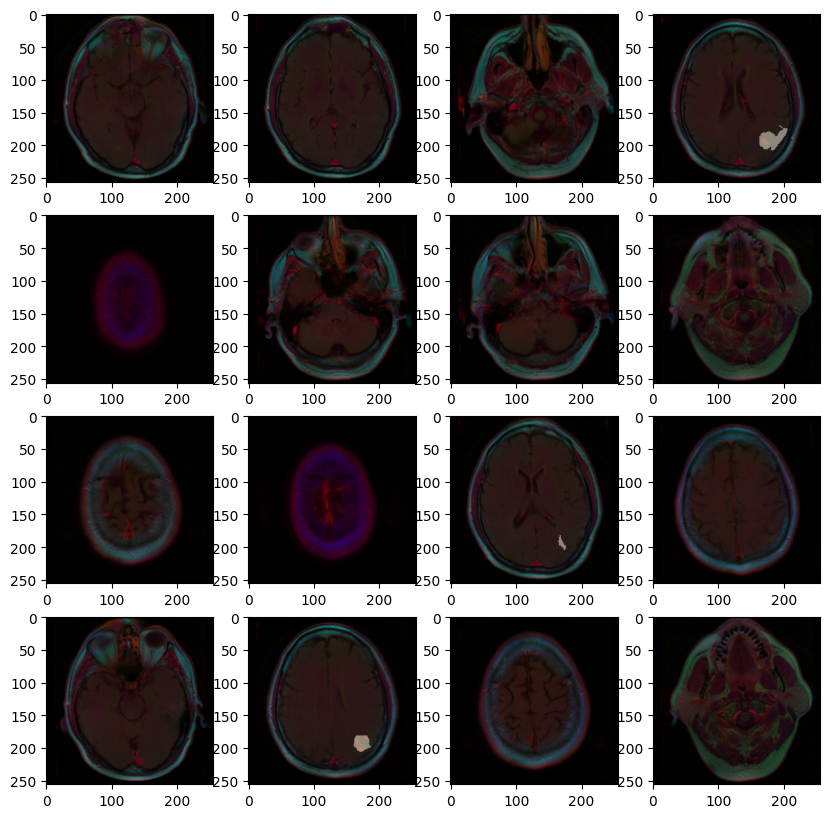

In [8]:
fig = plt.figure(figsize=(10, 10))
for i in range (1, 17):
    fig.add_subplot(4, 4, i)
    img = cv2.imread(train_files[i])
    msk = cv2.imread(mask_files[i])

    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# Each image file corresponds to its mask file
df = pd.DataFrame(data={"filename": train_files, 'mask': mask_files})

df_train, df_test = train_test_split(df, test_size = 0.1)
df_train, df_val = train_test_split(df_train, test_size = 0.2)
print(df_train.values.shape)
print(df_test.values.shape)
print(df_val.values.shape)

(2828, 2)
(393, 2)
(708, 2)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def train_generator(data_frame, batch_size, aug_dict,
                   image_color_mode = "rgb",
                   mask_color_mode = "grayscale",
                   image_save_prefix = "image",
                   mask_save_prefix = "mask",
                   save_to_dir = None,
                   target_size = (256, 256),
                   seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed
    )

    mask_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        seed = seed
    )

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        # print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
        yield (img, mask)



def adjust_data(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [11]:
# x: number of pixels in the predicted mask
# y: number of pixels in the ground truth mask
"""
    x_flat = x.flatten()
    y_flat = y.flatten()
    intersection = np.sum(y_flat, x_flat)
    intersection_sum = 2.0 * np.sum(intersection) + smooth

    x_sum = np.sum(x_flat)
    y_sum = np.sum(y_flat)
    union = x_sum + y_sum + smooth

    dice_coef = intersection_sum / union
    dice_coef_loss = -dice_coef
"""
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return (2. * And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth)

def dice_coefficient_loss(x, y):
    return 1 - dice_coef(x, y)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    w, h = input_tensor.shape[1], input_tensor.shape[2]

    for bin_size in bin_sizes:
        x = layers.AveragePooling2D(pool_size=(w // bin_size, h // bin_size), strides=(w // bin_size, h // bin_size))(input_tensor)
        x = layers.Conv2D(512, (1, 1), padding='same')(x)
        x = layers.UpSampling2D(size=(w // bin_size, h // bin_size), interpolation='bilinear')(x)
        concat_list.append(x)
    
    return layers.concatenate(concat_list)

def PSPNet(input_shape, num_classes):
    base_model = applications.ResNet50(input_shape=input_shape, include_top=False)
    base_out = base_model.output

    psp_out = pyramid_pooling_block(base_out, [1, 2, 3, 6])
    x = layers.Conv2D(512, (3, 3), padding='same')(psp_out)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.UpSampling2D(size=(input_shape[0] // 8, input_shape[1] // 8), interpolation='bilinear')(x)
    x = layers.Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(x)
    
    return models.Model(inputs=base_model.input, outputs=x)

input_shape = (256, 256, 3)
num_classes = 2
pspnet = PSPNet(input_shape, 1)
pspnet.summary()

2024-05-21 02:35:56.478825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 02:35:56.479285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 02:35:56.479637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 46,661,505 (178.00 MB)

 Trainable params: 46,607,361 (177.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

In [9]:
pspnet.compile(optimizer='adam', loss=dice_coefficient_loss, metrics=[dice_coef ,'accuracy', iou_metric])
train_generator_arguments = dict(rotation_range=0.2,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                shear_range=0.05,
                                zoom_range=0.05,
                                horizontal_flip=True,
                                fill_mode='nearest')


In [10]:
checkpoint = ModelCheckpoint('best_pspnet_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [11]:
batch_size = 8
im_height=256
im_width=256
train_gen = train_generator(df_train, 
                            batch_size,
                            train_generator_arguments,
                            target_size=(im_height, im_width))
val_gen = train_generator(df_val,
                          batch_size,
                          dict(),
                          target_size=(im_height, im_width))


In [12]:
import math

steps_per_epoch = math.floor(len(df_train) / batch_size)
validation_steps= math.floor(len(df_val) / batch_size)
EPOCHS=50

print('Validation Steps: ', validation_steps)
print('Steps per epoch: ', steps_per_epoch)

history = pspnet.fit(train_gen,
           steps_per_epoch=steps_per_epoch,
           epochs=EPOCHS,
           validation_data=val_gen,
           validation_steps= validation_steps,
           callbacks=callbacks_list)

Validation Steps:  88
Steps per epoch:  353
Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/50


I0000 00:00:1716240602.271419    2713 service.cc:145] XLA service 0x7c30b00045a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716240602.271452    2713 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-21 00:30:03.043808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 00:30:05.431717: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-21 00:30:09.424996: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 00:30:09.425032: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Al

353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9174 - dice_coef: 0.2599 - iou_metric: 0.1716 - loss: 0.7401Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to 1.00000, saving model to best_pspnet_model.keras
353/353 ━━━━━━━━━━━━━━━━━━━━ 110s 204ms/step - accuracy: 0.9175 - dice_coef: 0.2602 - iou_metric: 0.1718 - loss: 0.7398 - val_accuracy: 0.9884 - val_dice_coef: 3.4447e-06 - val_iou_metric: 3.5337e-04 - val_loss: 1.0000
Epoch 2/50


2024-05-21 00:31:37.598086: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 00:31:37.598131: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 00:31:37.958095: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 18.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-21 00:31:38.145514: W external/local_tsl/tsl/framework/bfc

  1/353 ━━━━━━━━━━━━━━━━━━━━ 1:29:58 15s/step - accuracy: 0.9817 - dice_coef: 6.8449e-08 - iou_metric: 2.0797e-04 - loss: 1.0000

I0000 00:00:1716240707.655901    2710 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_24', 20 bytes spill stores, 20 bytes spill loads



353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9904 - dice_coef: 0.4977 - iou_metric: 0.3602 - loss: 0.4989
Epoch 2: val_loss improved from 1.00000 to 0.99973, saving model to best_pspnet_model.keras
353/353 ━━━━━━━━━━━━━━━━━━━━ 85s 199ms/step - accuracy: 0.9904 - dice_coef: 0.4977 - iou_metric: 0.3602 - loss: 0.4989 - val_accuracy: 0.9885 - val_dice_coef: 2.7278e-04 - val_iou_metric: 0.0162 - val_loss: 0.9997
Epoch 3/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9915 - dice_coef: 0.5445 - iou_metric: 0.4037 - loss: 0.4533
Epoch 3: val_loss improved from 0.99973 to 0.52260, saving model to best_pspnet_model.keras
353/353 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.9915 - dice_coef: 0.5445 - iou_metric: 0.4037 - loss: 0.4533 - val_accuracy: 0.9910 - val_dice_coef: 0.4747 - val_iou_metric: 0.3590 - val_loss: 0.5226
Epoch 4/50
353/353 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9916 - dice_coef: 0.5553 - iou_metric: 0.4138 - loss: 0.4452
Epoch 4: val_los

### Load the saved model

In [13]:
model = tf.keras.models.load_model('best_pspnet_model.keras', custom_objects={
    'dice_coefficient_loss': dice_coefficient_loss,
    'dice_coef': dice_coef,
    'iou_metric': iou_metric
})

I0000 00:00:1716248251.895295    7261 service.cc:145] XLA service 0x791bc0003a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716248251.895332    7261 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-21 02:37:32.009806: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-21 02:37:32.396693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1716248254.222313    7261 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


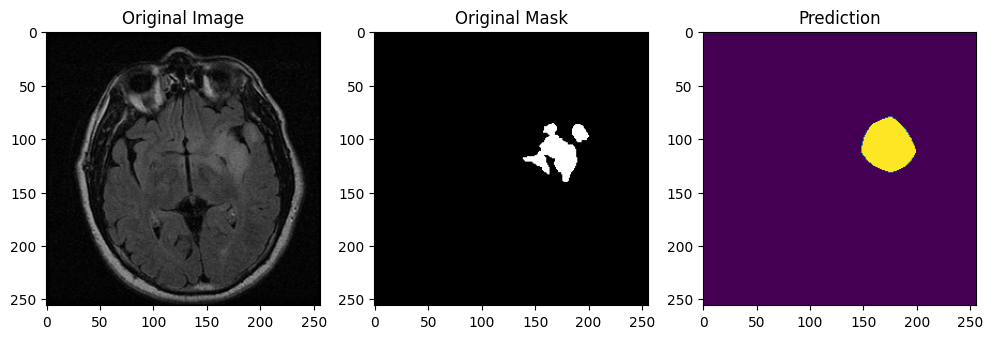

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


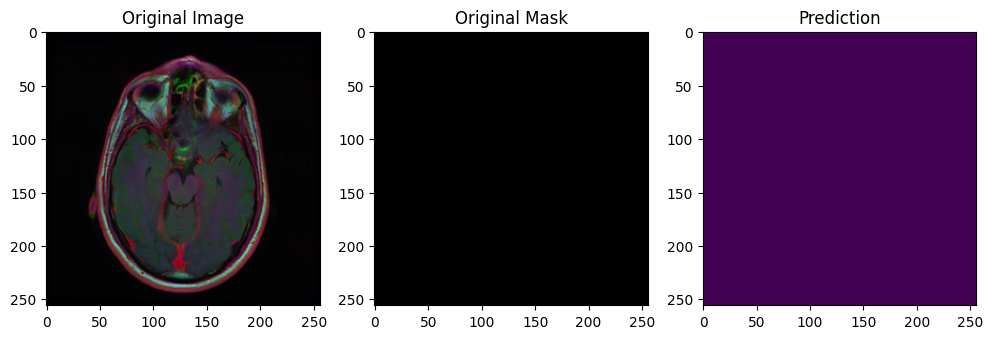

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


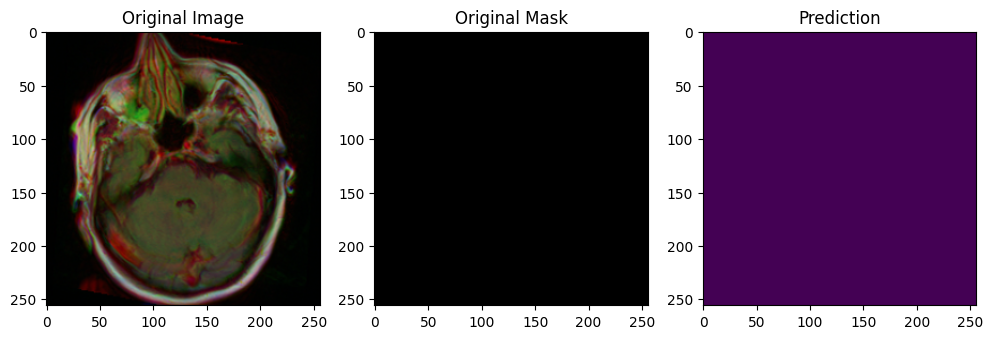

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


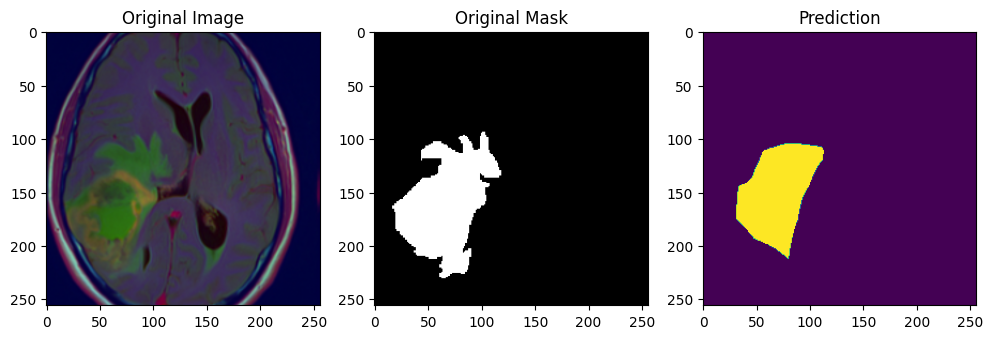

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


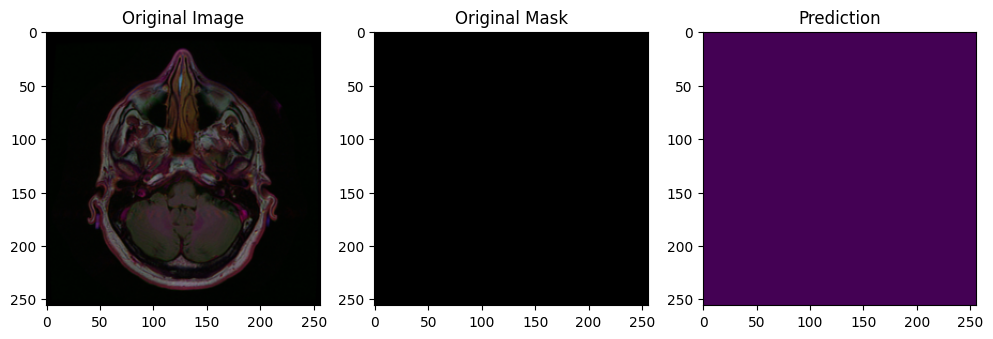

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


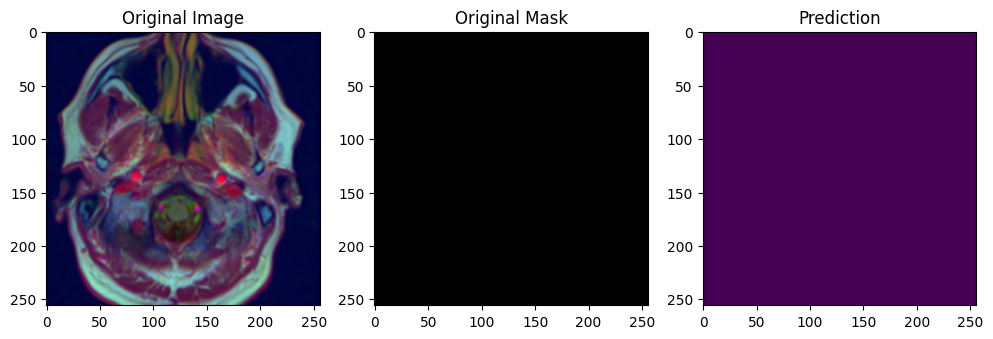

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


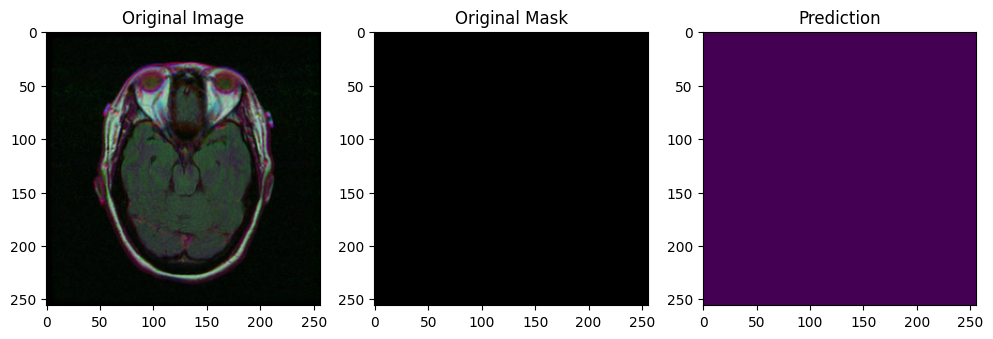

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


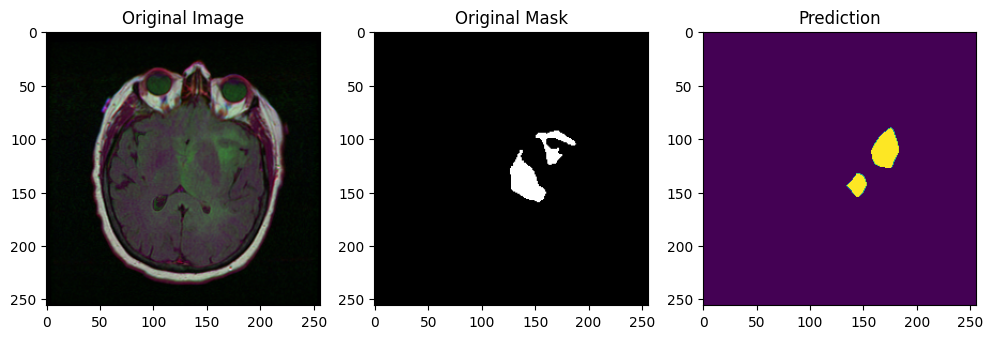

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


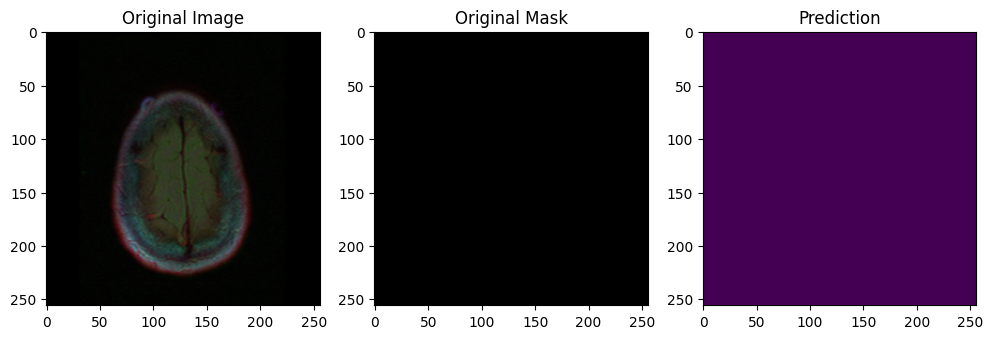

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


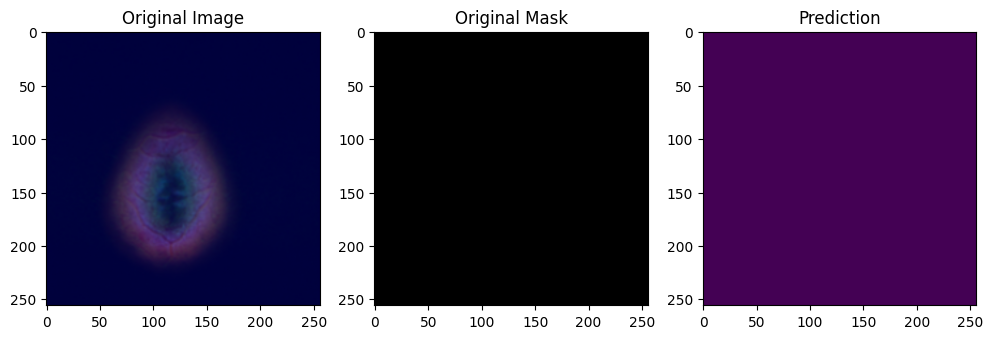

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


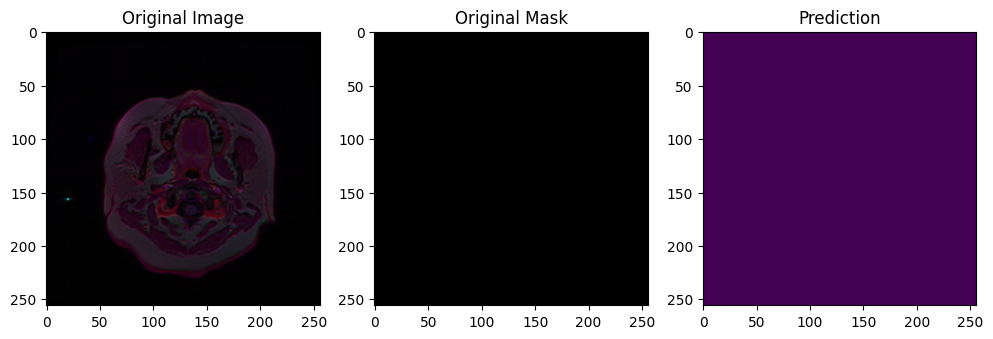

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


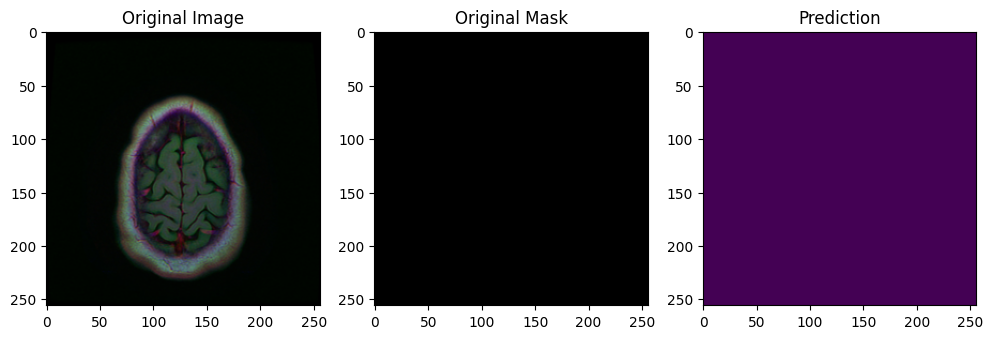

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


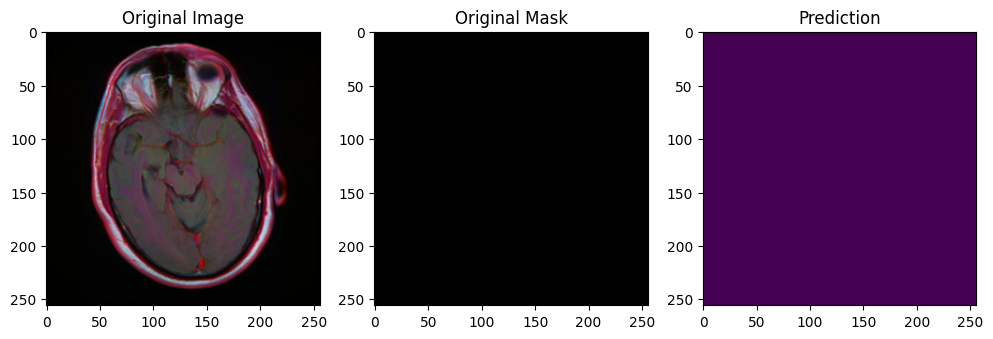

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


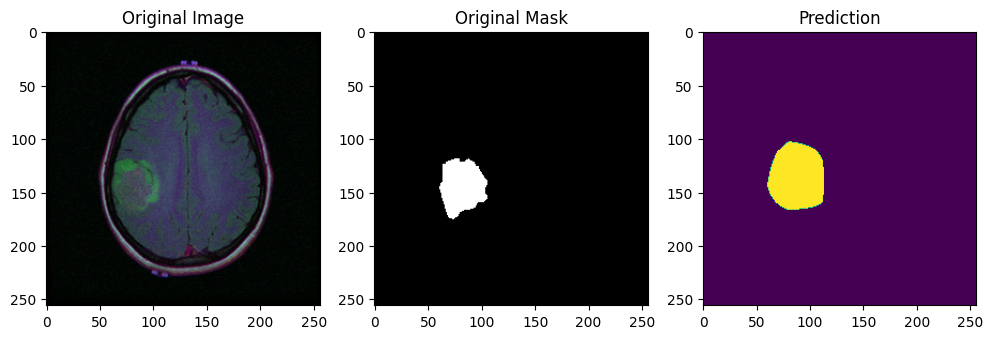

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


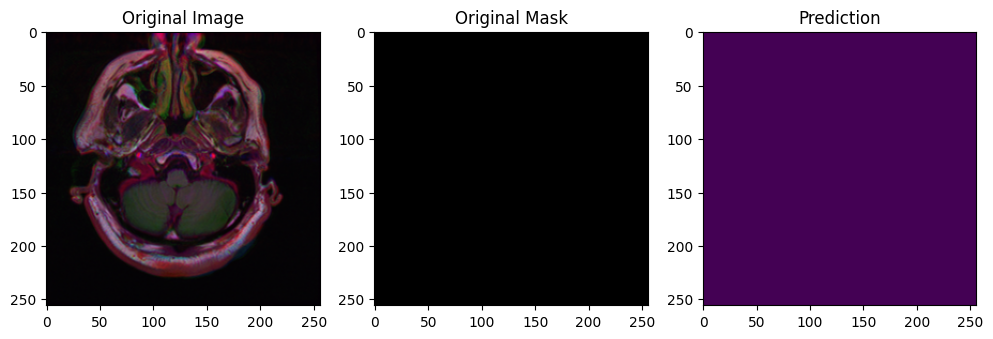

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


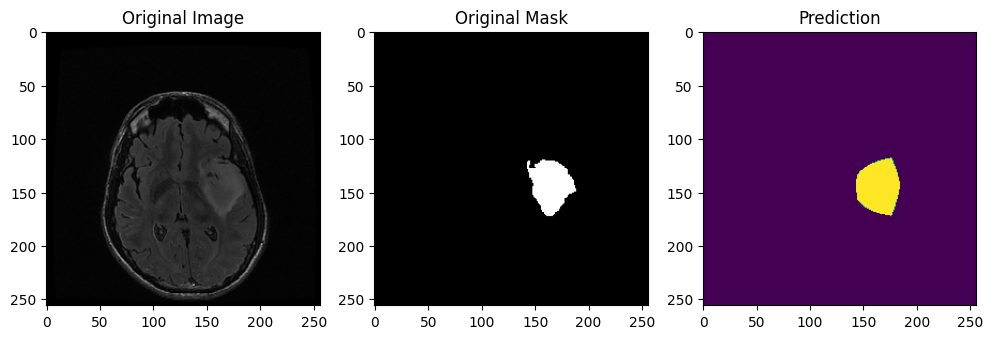

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


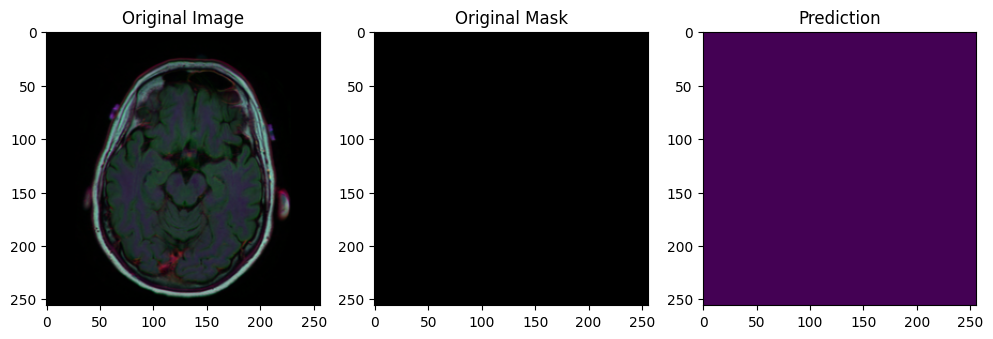

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


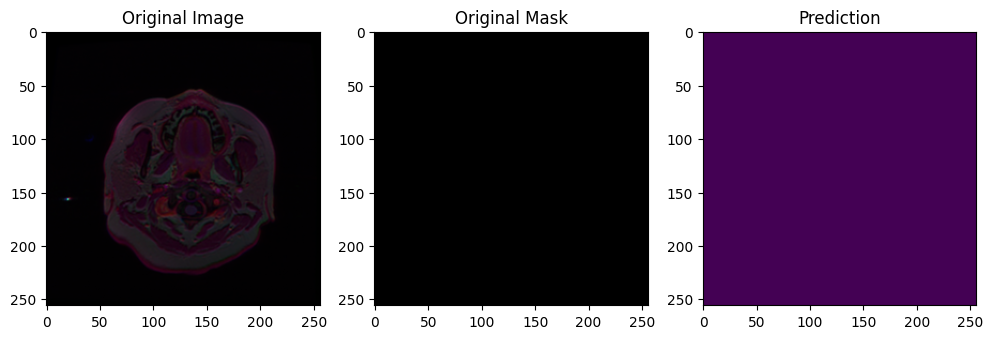

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


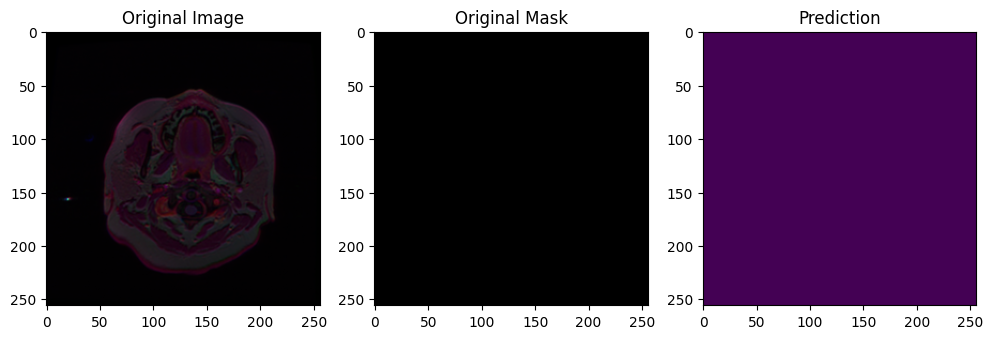

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


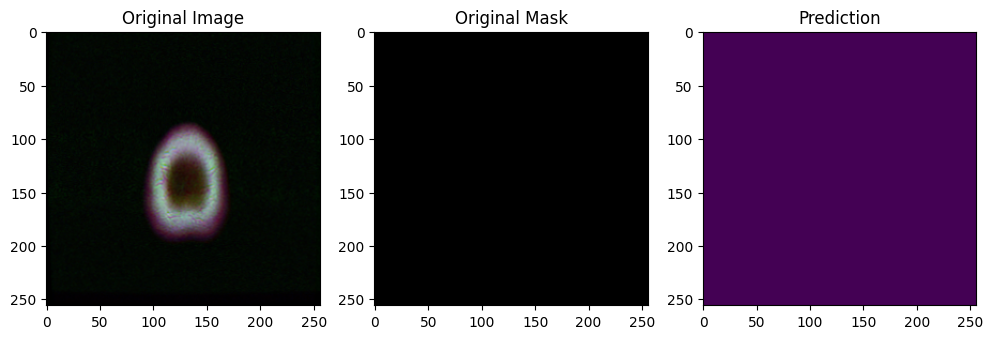

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


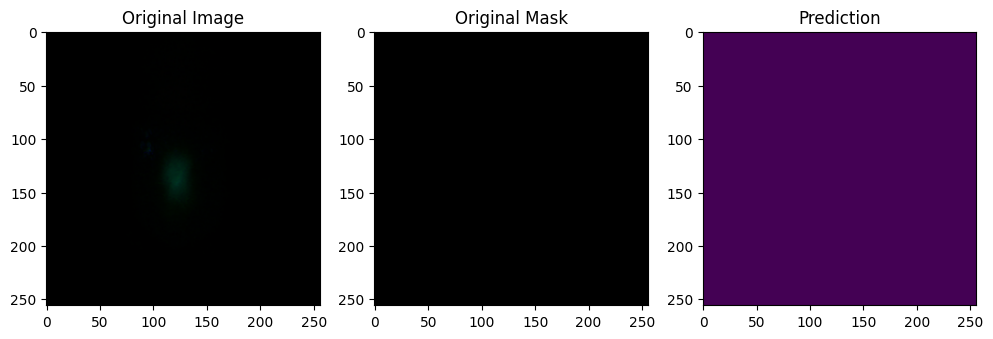

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


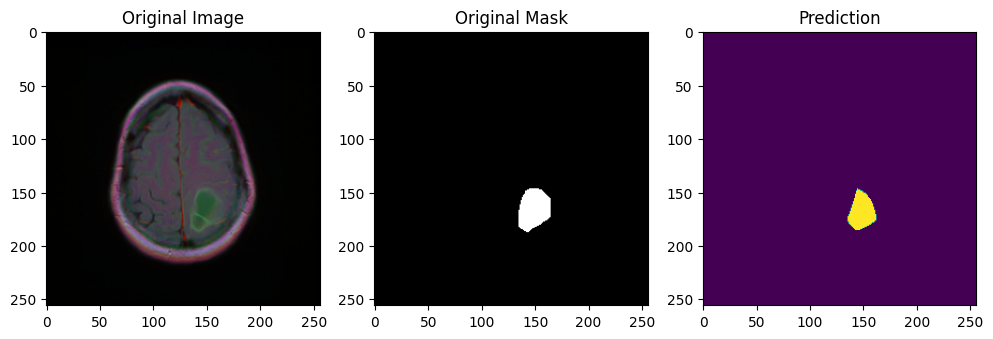

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


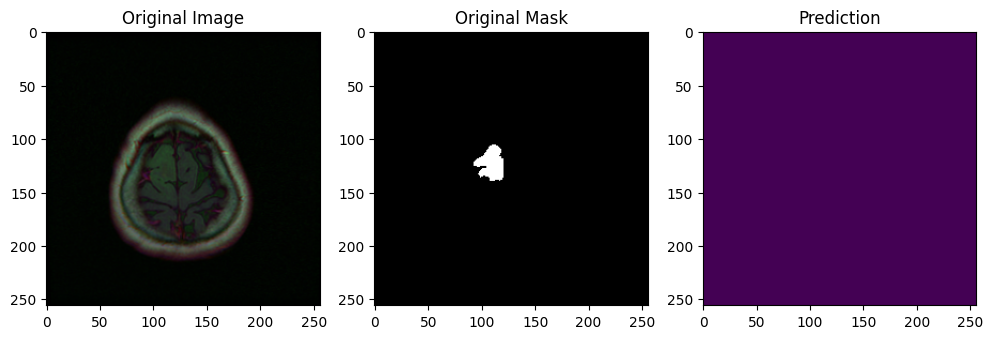

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


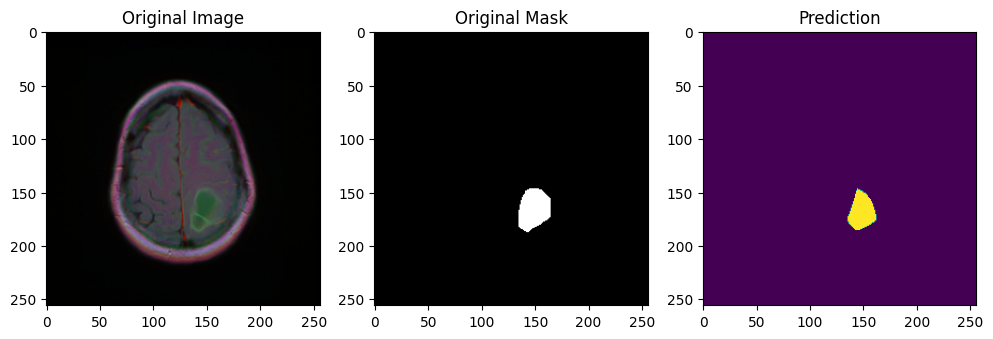

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


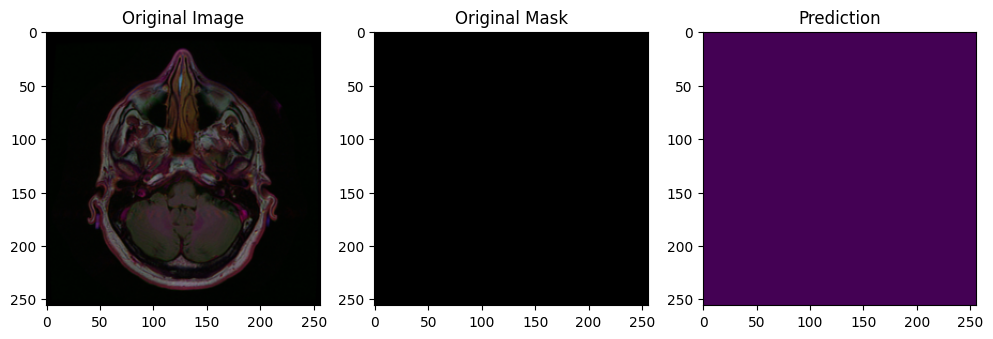

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


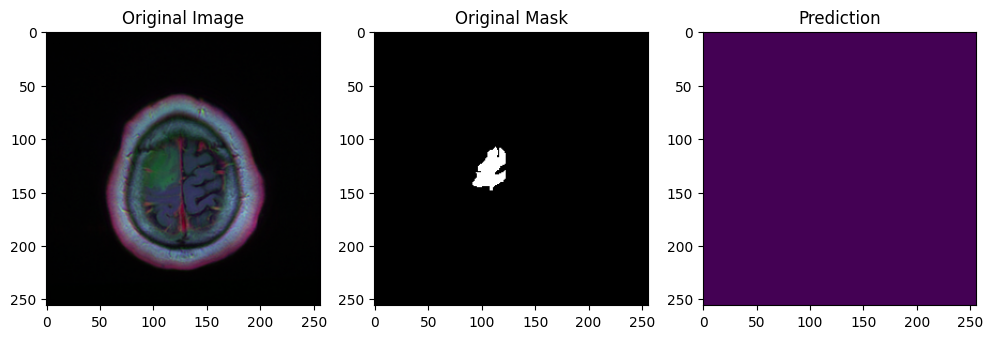

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


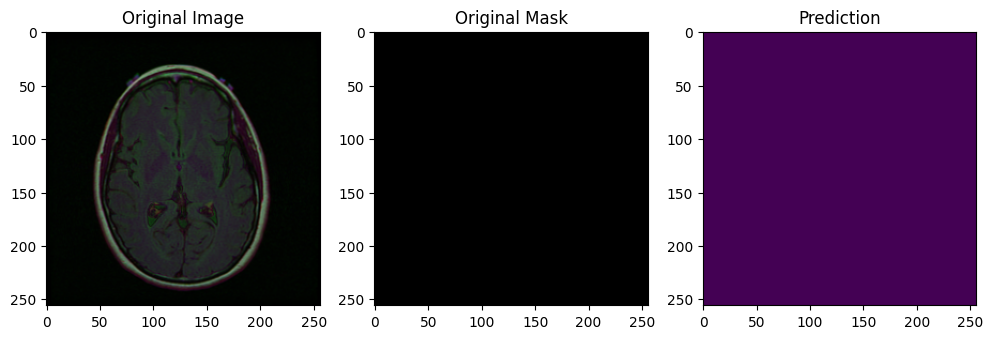

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


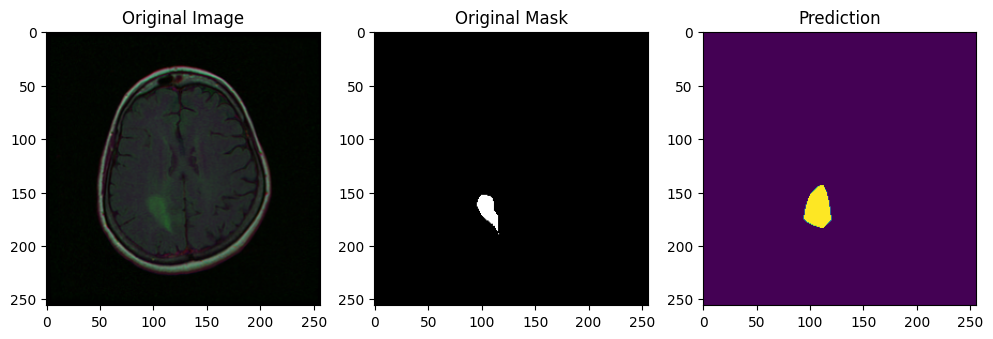

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


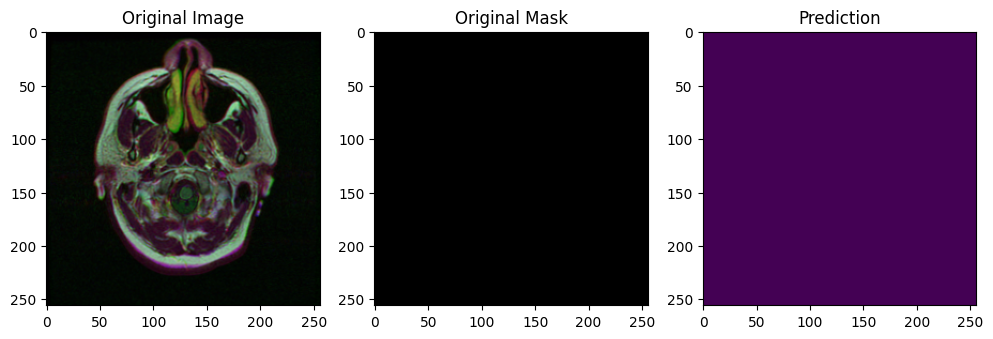

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


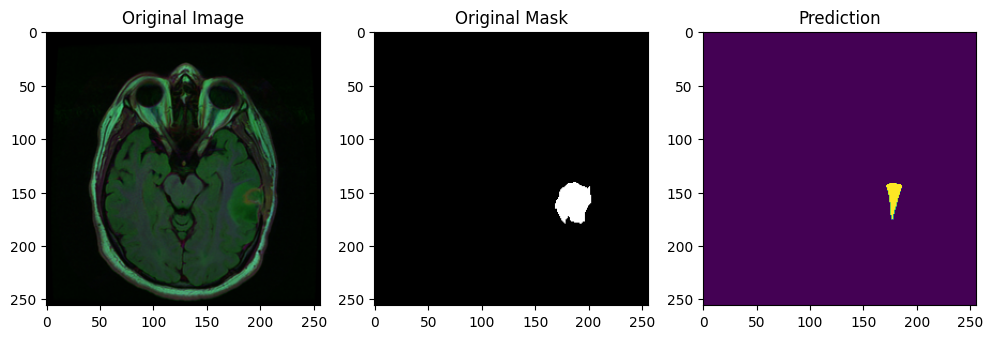

In [16]:
im_height=256
im_width=256
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()


### Testing and Evaluating

In [17]:
batch_size = 8
im_height=256
im_width=256

print(len(df_test))
test_gen = train_generator(df_test,
                          batch_size,
                          dict(),
                          target_size=(im_height, im_width))



test_steps = len(df_test) // batch_size

test_loss, test_dice_coef, test_accuracy, test_iou_metric = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test IoU Metric: {test_iou_metric}")

393
Found 393 validated image filenames.
Found 393 validated image filenames.
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9947 - dice_coef: 0.7132 - iou_metric: 0.5743 - loss: 0.2868
Test Loss: 0.29473796486854553
Test Dice Coefficient: 0.7052620053291321
Test Accuracy: 0.9954032301902771
Test IoU Metric: 0.5773692727088928
